# Set up environment

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Test if GPU is available
# Note that CUDA below 12.1 can have bugs
import torch
print(torch.cuda.is_available())
# print(torch.cuda.get_device_name(0))
print(torch.version.cuda)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

True
12.1


In [3]:
#%% import libraries
import os
from collections import defaultdict
import sys

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import copy
import numpy as np
import numpy.random
from numpy.fft import fft as fft
from numpy.fft import ifft as ifft
import pickle
from sklearn.linear_model import PoissonRegressor
from sklearn.model_selection import KFold
from sklearn.manifold import TSNE
import scipy.stats
from scipy.stats import wilcoxon, chi2
import scipy.interpolate 
import scipy.signal
from scipy import linalg
from scipy.special import rel_entr
from tqdm import tqdm
import pandas as pd
import joblib
import logging

import statsmodels.api as sm
import statsmodels.genmod.generalized_linear_model as smm

import torch
from torch.autograd import Variable
from torch.nn import functional as F
import torch.nn as nn
import torch.optim as optim

In [4]:
# import my code
from FCGPFA import gpfa_poisson_fix_weights, make_4d_diagonal, get_K
from FCGPFA import conv, conv_subspace
import utility_functions as utils
import GLM
from DataLoader import Allen_dataset, Allen_dataloader_multi_session
from model_trainer import Trainer

/home/qix/anaconda3/envs/allen/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load data

In [5]:
# Load from toy dataloader with two sessions
if sys.platform == 'linux':
    data_path = '/home/qix/user_data/allen_spike_trains/two_session_toy_dataloader.joblib'
else:
    data_path = 'D:/ecephys_cache_dir/two_session_toy_dataloader.joblib'
two_session_toy_dataloader = joblib.load(data_path)

In [6]:
# Load from toy dataloader full of only 1 and 2
if sys.platform == 'linux':
    data_path = '/home/qix/user_data/allen_spike_trains/dummy_dataloader.joblib'
else:
    data_path = 'D:/ecephys_cache_dir/dummy_dataloader.joblib'
dummy_dataloader = joblib.load(data_path)

# Train a model

Things I want to try:
- with all parameters not frozen (running now). See how it compares to the model with readout matrix frozen (0.0642). **Yes, it's a tiny bit better 1e-4.**
- Use more factors for the stimulus effect. **Yes, it improves 0.064 -> 0.063.**
- Increase the number of B-spline basis to see if it capture shift in peaks. **Yes, it improves 1e-4.**
- Use inhomogeneous baseline + var as the trial-wise stimulus effect. So the VAE only needs to learn the difference across trials.

In [105]:
# data_to_use = cross_session_dataloader
data_to_use = two_session_toy_dataloader
# data_to_use = dummy_dataloader
ckp_path = '/home/qix/user_data/VAETransformer_checkpoint'

torch.manual_seed(0)
np.random.seed(0)

params = {
    # B-spline basis
    'num_B_spline_basis': 20,
    # Transformer VAE's settings
    'downsample_factor': 10,
    'transformer_num_layers': 2,
    'transformer_d_model': 128,
    'transformer_dim_feedforward': 512,
    'transformer_vae_output_dim': 8,
    'transformer_dropout': 0.0,
    'transformer_nhead': 2,
    'stimulus_nfactor': 4,
    'stimulus_decoder_inter_dim_factor': 4,
    'beta': 1.0,
    # Coupling's settings
    'coupling_basis_peaks_max': 20,
    'coupling_basis_num': 3,
    'coupling_nsubspace': 1,
    'use_self_coupling': True,
    # Coupling strength latent's settings
    'K_sigma2': 1.0,
    'K_tau': 100,
    'coupling_strength_nlatent': 1,
    # Penalty settings
    'penalty_overlapping': None, 
    # Training settings
    'batch_size': 64,
    'sample_latent': False,
    'lr': 1e-3,
    'epoch_warm_up': 0,
    'epoch_patience': 3,
    'epoch_max': 50,
    'tol': 1e-4,
    # Currently not used
    'weight_decay': 0.0,
    'lr_transformer': 1e-4,
    'lr_sti': 1e-2,
    'lr_cp': 1e-2,
}

trainer = Trainer(data_to_use, ckp_path, params)
# First step: train the model with a trial-invariant stimulus effect
trainer.train(
    include_stimulus=True,
    include_coupling=False,
    fix_stimulus=True,
    fix_latents=True,
    verbose=True,
)
# Second step: train the model with a trial-varying stimulus effect
# trainer.make_optimizer(frozen_params=['sti_readout'])
trainer.make_optimizer(frozen_params=[])
trainer.train(
    include_stimulus=True,
    include_coupling=False,
    fix_stimulus=False,
    fix_latents=True,
    verbose=True,
)
# trainer.train(
#     include_stimulus=True,
#     include_coupling=True,
#     fix_stimulus=False,
#     fix_latents=True,
#     verbose=True,
# )

Total sessions: 2, Batch size: 64, Train set size: 266, Val set size: 38, Test set size: 76
Model initialized. Training on cuda
Start training model with parameters: {'num_B_spline_basis': 40, 'downsample_factor': 10, 'transformer_num_layers': 2, 'transformer_d_model': 128, 'transformer_dim_feedforward': 512, 'transformer_vae_output_dim': 8, 'transformer_dropout': 0.0, 'transformer_nhead': 2, 'stimulus_nfactor': 4, 'stimulus_decoder_inter_dim_factor': 4, 'beta': 1.0, 'coupling_basis_peaks_max': 20, 'coupling_basis_num': 3, 'coupling_nsubspace': 1, 'use_self_coupling': True, 'K_sigma2': 1.0, 'K_tau': 100, 'coupling_strength_nlatent': 1, 'penalty_overlapping': None, 'batch_size': 64, 'sample_latent': False, 'lr': 0.001, 'epoch_warm_up': 0, 'epoch_patience': 3, 'epoch_max': 50, 'tol': 0.0001, 'weight_decay': 0.0, 'lr_transformer': 0.0001, 'lr_sti': 0.01, 'lr_cp': 0.01}


100%|██████████| 38/38 [00:10<00:00,  3.70it/s]


Epoch 1/50, Train Loss: 0.2177, Test Loss: 0.0658


100%|██████████| 38/38 [00:10<00:00,  3.66it/s]


Epoch 2/50, Train Loss: 0.0653, Test Loss: 0.0649


100%|██████████| 38/38 [00:10<00:00,  3.70it/s]


Epoch 3/50, Train Loss: 0.0649, Test Loss: 0.0648


100%|██████████| 38/38 [00:10<00:00,  3.69it/s]


Epoch 4/50, Train Loss: 0.0649, Test Loss: 0.0648
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.0648


100%|██████████| 38/38 [00:10<00:00,  3.70it/s]


Epoch 5/50, Train Loss: 0.0649, Test Loss: 0.0648
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.0648


100%|██████████| 38/38 [00:10<00:00,  3.67it/s]
/home/qix/FC-GPFA/model_trainer.py:255: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(t

Epoch 6/50, Train Loss: 0.0649, Test Loss: 0.0648
No improvement in Test Loss for 3 epoch(s).
Current Best Test Loss: 0.0648
Early stopping triggered.
Start training model with parameters: {'num_B_spline_basis': 40, 'downsample_factor': 10, 'transformer_num_layers': 2, 'transformer_d_model': 128, 'transformer_dim_feedforward': 512, 'transformer_vae_output_dim': 8, 'transformer_dropout': 0.0, 'transformer_nhead': 2, 'stimulus_nfactor': 4, 'stimulus_decoder_inter_dim_factor': 4, 'beta': 1.0, 'coupling_basis_peaks_max': 20, 'coupling_basis_num': 3, 'coupling_nsubspace': 1, 'use_self_coupling': True, 'K_sigma2': 1.0, 'K_tau': 100, 'coupling_strength_nlatent': 1, 'penalty_overlapping': None, 'batch_size': 64, 'sample_latent': False, 'lr': 0.001, 'epoch_warm_up': 0, 'epoch_patience': 3, 'epoch_max': 50, 'tol': 0.0001, 'weight_decay': 0.0, 'lr_transformer': 0.0001, 'lr_sti': 0.01, 'lr_cp': 0.01}


100%|██████████| 38/38 [00:10<00:00,  3.71it/s]


Epoch 1/50, Train Loss: 0.0912, Test Loss: 0.0646


100%|██████████| 38/38 [00:10<00:00,  3.70it/s]


Epoch 2/50, Train Loss: 0.0645, Test Loss: 0.0645


100%|██████████| 38/38 [00:10<00:00,  3.69it/s]


Epoch 3/50, Train Loss: 0.0644, Test Loss: 0.0643


100%|██████████| 38/38 [00:10<00:00,  3.70it/s]


Epoch 4/50, Train Loss: 0.0643, Test Loss: 0.0642


100%|██████████| 38/38 [00:10<00:00,  3.71it/s]


Epoch 5/50, Train Loss: 0.0641, Test Loss: 0.0640


100%|██████████| 38/38 [00:10<00:00,  3.70it/s]


Epoch 6/50, Train Loss: 0.0639, Test Loss: 0.0638


100%|██████████| 38/38 [00:10<00:00,  3.71it/s]


Epoch 7/50, Train Loss: 0.0638, Test Loss: 0.0637


100%|██████████| 38/38 [00:10<00:00,  3.70it/s]


Epoch 8/50, Train Loss: 0.0637, Test Loss: 0.0637
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.0637


100%|██████████| 38/38 [00:10<00:00,  3.71it/s]


Epoch 9/50, Train Loss: 0.0635, Test Loss: 0.0634


100%|██████████| 38/38 [00:10<00:00,  3.71it/s]


Epoch 10/50, Train Loss: 0.0633, Test Loss: 0.0633


100%|██████████| 38/38 [00:10<00:00,  3.72it/s]


Epoch 11/50, Train Loss: 0.0633, Test Loss: 0.0632
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.0633


100%|██████████| 38/38 [00:10<00:00,  3.70it/s]


Epoch 12/50, Train Loss: 0.0632, Test Loss: 0.0632


100%|██████████| 38/38 [00:10<00:00,  3.71it/s]


Epoch 13/50, Train Loss: 0.0631, Test Loss: 0.0630


100%|██████████| 38/38 [00:10<00:00,  3.70it/s]


Epoch 14/50, Train Loss: 0.0630, Test Loss: 0.0630
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.0630


100%|██████████| 38/38 [00:10<00:00,  3.70it/s]


Epoch 15/50, Train Loss: 0.0630, Test Loss: 0.0629


100%|██████████| 38/38 [00:10<00:00,  3.68it/s]


Epoch 16/50, Train Loss: 0.0629, Test Loss: 0.0628
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.0629


100%|██████████| 38/38 [00:10<00:00,  3.69it/s]


Epoch 17/50, Train Loss: 0.0628, Test Loss: 0.0628
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.0629


100%|██████████| 38/38 [00:10<00:00,  3.70it/s]

Epoch 18/50, Train Loss: 0.0628, Test Loss: 0.0633
No improvement in Test Loss for 3 epoch(s).
Current Best Test Loss: 0.0629
Early stopping triggered.



/home/qix/FC-GPFA/model_trainer.py:255: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(temp_best_model_path))


0.0629153322232397

In [106]:
# Compare the model's prediction with a baseline model
### Which dataset to use?
loader = trainer.dataloader.train_loader

###
trainer.model.eval()
trainer.model.sample_latent = False
test_loss = 0.0
test_loss_baseline = 0.0
total_trial = 0
test_loss_record = []
with torch.no_grad():
    for i, batch in enumerate(tqdm(loader)):
        trainer.process_batch(batch)
        firing_rate = trainer.model(
            batch,
            include_stimulus=True,
            include_coupling=False,
            fix_stimulus=False,
            fix_latents=True,
        )
        loss = trainer.model.loss_function(
            firing_rate, 
            batch["spike_trains"][trainer.npadding:,:,:], 
            trainer.model.sti_mu, 
            trainer.model.sti_logvar, 
            beta=trainer.params['beta']
        )
        test_loss_record.append(loss.item())
        test_loss += loss.item() * batch["spike_trains"].size(2)
        total_trial += batch["spike_trains"].size(2)
        if i==0 or firing_rate_baseline.shape != batch["spike_trains"][trainer.npadding:,:,:].shape:
            firing_rate_baseline = (
                torch.log(torch.clamp(batch["spike_trains"][trainer.npadding:,:,:].mean(dim=(0,2)), min=1e-4))[None,:,None] \
                    * torch.ones_like(batch["spike_trains"][trainer.npadding:,:,:])
            )
        loss_baseline = trainer.model.loss_function(
            firing_rate_baseline, 
            batch["spike_trains"][trainer.npadding:,:,:], 
            trainer.model.sti_mu, 
            trainer.model.sti_logvar, 
            beta=trainer.params['beta']
        )
        test_loss_baseline += loss_baseline.item() * batch["spike_trains"].size(2)

test_loss /= total_trial
test_loss_baseline /= total_trial
print(f"Test loss: {test_loss}")
print(f"Test loss baseline: {test_loss_baseline}")

100%|██████████| 266/266 [01:09<00:00,  3.82it/s]

Test loss: 0.06290855832579681
Test loss baseline: 0.06550229648522551


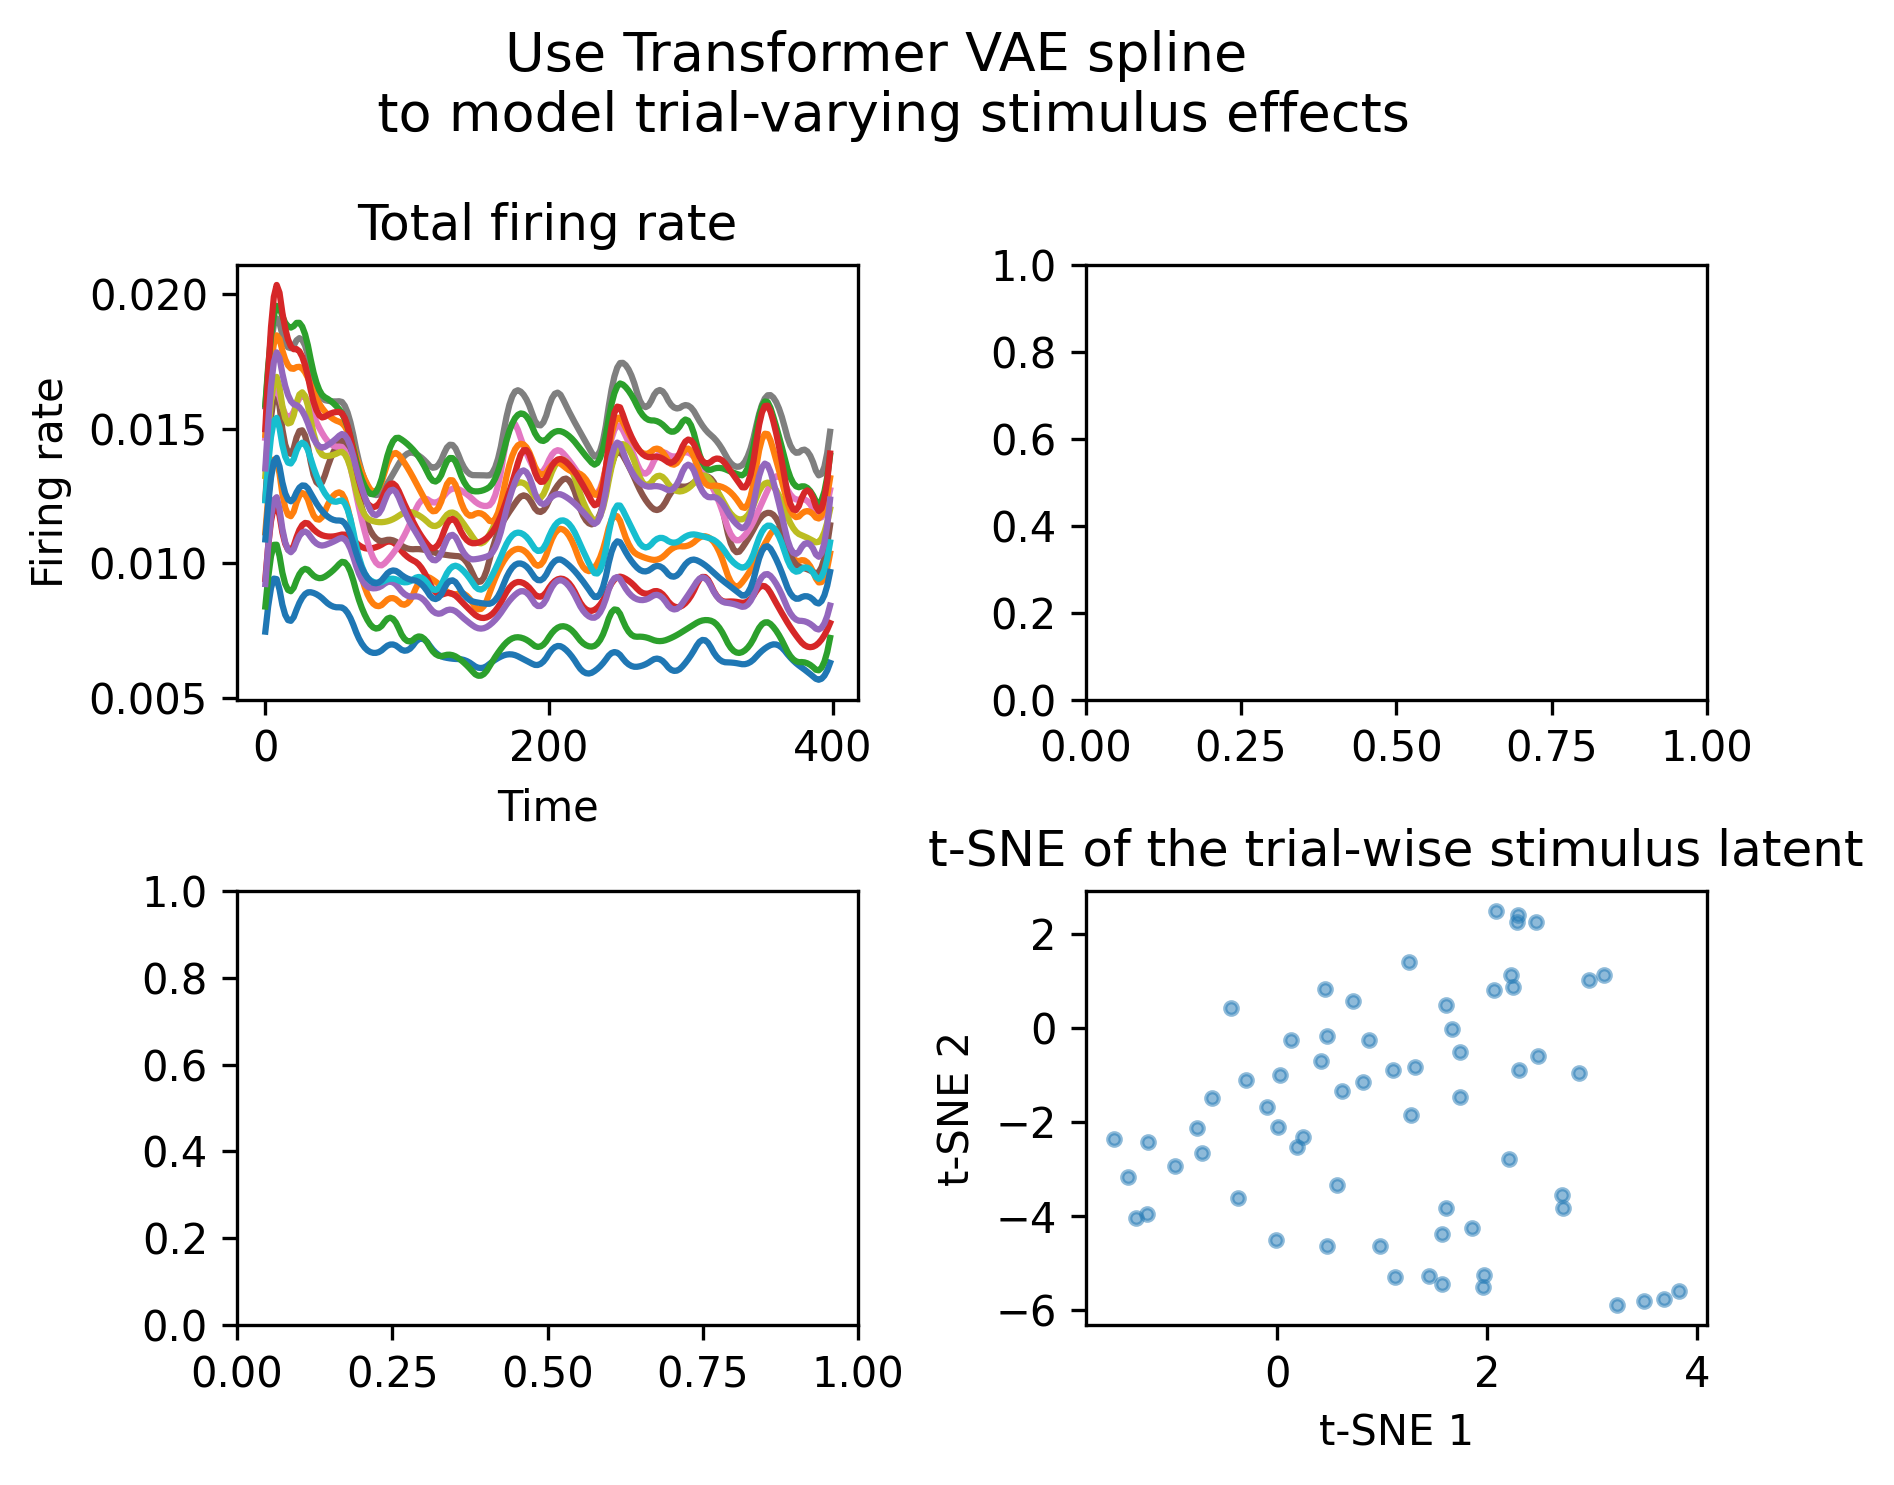

In [109]:
trial_indices = np.arange(0, 15)
neuron_idx = 40

firing_rate_test, sti_mu_test, sti_logvar_test = trainer.predict(
    dataset='test',
    batch_indices=[9],
    return_torch=True, 
    include_stimulus=True,
    include_coupling=False, 
    fix_stimulus=False,
    fix_latents=True, 
)

# Create a 2x2 subplot figure
fig, axes = plt.subplots(2, 2, figsize=(6, 5) ,dpi=300)
fig.suptitle('Use Transformer VAE spline \n to model trial-varying stimulus effects', fontsize=13)

# Plot total firing rate
xx = np.arange(0, 400, 2)
axes[0,0].plot(xx, np.exp(firing_rate_test[:, neuron_idx, trial_indices].numpy()))
# axes[0,0].plot(xx, firing_rate_test[:, neuron_idx, trial_indices].numpy())
axes[0,0].set_title('Total firing rate')
axes[0,0].set_xlabel('Time')
axes[0,0].set_ylabel('Firing rate')
# axes[0,0].legend([f'Trial {i+1}' for i in range(trainer.model.firing_rates_stimulus.shape[2])], 
#                  bbox_to_anchor=(1.01, 1), loc='upper left', fontsize=6)

# Plot coupling effect
# axes[0,1].plot(trainer.model.firing_rates_coupling[:, neuron_idx, trial_indices].cpu().numpy().T)
# axes[0,1].set_title('Coupling Effect')
# axes[0,1].set_xlabel('Time')
# axes[0,1].set_ylabel('log firing rate')

# Plot stimulus effect
# axes[1,0].plot(trainer.model.firing_rates_stimulus[:, neuron_idx, trial_indices].cpu().numpy().T)
# axes[1,0].set_title('Stimulus Effect')
# axes[1,0].set_xlabel('Time')
# axes[1,0].set_ylabel('log firing rate')

# Plot t-SNE in the last subplot
sti_mu_test_np = sti_mu_test.detach().cpu().numpy() if torch.is_tensor(sti_mu_test) else sti_mu_test
if np.all(sti_mu_test_np.std(axis=0) > 1e-3):
    tsne = TSNE(n_components=2, random_state=42)
    sti_mu_test_tsne = tsne.fit_transform(sti_mu_test_np)
    axes[1,1].scatter(sti_mu_test_tsne[:, 0], sti_mu_test_tsne[:, 1], alpha=0.5, marker='.')
    axes[1,1].set_title('t-SNE of the trial-wise stimulus latent')
    axes[1,1].set_xlabel('t-SNE 1')
    axes[1,1].set_ylabel('t-SNE 2')
else:
    print(f"Stimulus latent is not varying across trials: {sti_mu_test_np.std(axis=0).mean()}")

plt.tight_layout()
# plt.savefig('Figure/all_effects_and_tsne0.pdf', bbox_inches='tight', dpi=300)